## Multiple Sequence Alignment

The aim of this notebook is to conduct a multiple sequence alignment (henceforth MSA). MSA methods refer to a series of algorithmic solution for the alignment of evolutionarily related sequences, while taking into account evolutionary events such as mutations, insertions, deletions and rearrangements under certain conditions. These methods can be applied to DNA, RNA or protein sequences. (https://academic.oup.com/bib/article/17/6/1009/2606431)
We will use the files of XML format (`curated_uniprot.fasta_`) with the information of hsp regions and the amino acid sequences.

In [1]:
# Importing the libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from Bio import AlignIO, SeqIO
import ipywidgets as widgets
from functions import *

In [2]:
# Set a working directory
directory = os.getcwd()

### 1. Data Preparation

We have defined a function that parses an XML file with the BLAST alignment into a pandas dataframe. This function can be utilized to include any additional columns from the BLAST results.

In [232]:
# Open XML file in a dataframe
input_file = '{}/databases/uniprot/curated_uniprot.fasta_0'.format(directory) # change the file name if necessary
df = blast_parser(input_file)
df.head(5)

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,Q9Y6K1,Q9Y6K1,912,912,MPAMPSSGPGDTSSSAAEREEDRKDGEEQEEPRGKEERQEPSTTAR...,MPAMPSSGPGDTSSSAAEREEDRKDGEEQEEPRGKEERQEPSTTAR...,MPAMPSSGPGDTSSSAAEREEDRKDGEEQEEPRGKEERQEPSTTAR...,1,912,1,912,912,912,0,0.0,4888.0,200
1,Q9Y6K1,A0A834A2B5,912,835,MAQDSGASELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEGAAE...,MAQDSG+SELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEG AE...,MAQDSGSSELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEGTAE...,78,912,1,835,813,821,0,0.0,4396.0,200
2,Q9Y6K1,A0A8D0SHE5,912,844,MAQDSGASELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEGAAE...,MAQDSG SELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEGAAE...,MAQDSGPSELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEGAAE...,78,912,1,844,818,825,9,0.0,4398.0,200
3,Q9Y6K1,A0A5G2R012,912,844,MAQDSGASELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEGAAE...,MAQDSG SELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEGAAE...,MAQDSGPSELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEGAAE...,78,912,1,844,818,825,9,0.0,4398.0,200
4,Q9Y6K1,A0A287AKK4,912,883,MPSSGPGDTSSSAAEREEDRKDGEEQEEPRGKEERQEPSTTARKVG...,MP+SGPGDTS SA EREEDRK+GEEQEE RGKEERQEPSTT RKVG...,MPASGPGDTSGSAPEREEDRKEGEEQEEARGKEERQEPSTTTRKVG...,4,883,1,883,845,855,3,0.0,4401.0,200


### Filtering disordered regions in MSA

We convert the file `curated.mjson` to dataframe in order to retrieve the IDs and disordered regions.

In [233]:
# Create a dataframe with Disprot instances from curated.mjson database
data = list()

with open('curated.mjson', 'r') as file:
    for line in file:
        obj = json.loads(line)
        rows = json_parser(obj)
        data.extend(rows)

curated_disprot = pd.DataFrame(data)

# Calculate the length of disordered regions
curated_disprot['length'] = curated_disprot['end'] - curated_disprot['start'] + 1
curated_disprot = curated_disprot[(curated_disprot['feature'] == 'disorder') & (curated_disprot['source'] == 'disprot')]

print(f"The number of the Curated Disprot database instances: {len(curated_disprot)}")
curated_disprot.head()

The number of the Curated Disprot database instances: 3151


,acc,evidence,feature,source,start,end,length
6927,P03265,curated,disorder,disprot,294,334,41
6928,P03265,curated,disorder,disprot,454,464,11
6929,P49913,curated,disorder,disprot,134,170,37
6930,P03045,curated,disorder,disprot,1,107,107
6931,P00004,curated,disorder,disprot,1,105,105


After identifying the IDs and disordered regions, we can use these data to filter the initial dataframe.

In [234]:
# Keep only disordered regions in the initial dataframe filtering using curated_disordered dataframe
disordered = df[df['query_id'].isin(curated_disprot['acc'])]
disordered.to_csv("disordered_df.csv", index=False)

print(f"The number of rows containing disordered regions: {len(disordered)}")
disordered.head(5)

The number of rows containing disordered regions: 4506


,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
600,P00742,S7Q6R4,488,482,GESLFIRREQANNILARVTRANSFLEEMKKGHLERECMEETCSYEE...,G S+FI+RE AN+ L RV NS EE K+ LE EC+EETC YEE...,GGSVFIKREHANSFLDRV---NSLSEETKREDLESECVEETCHYEE...,21,482,21,498,328,375,24,0.0,1693.0,200
601,P00742,Q9GMD9,488,474,MGRPLHLVLLSASLAGLLLLGESLFIRREQANNILARVTRANSFLE...,M LHLVLL A L+ L E++FI +E AN +L R RANS E...,MAGRLHLVLLFAFLSALPPAVENVFINQEDANKVLGRAKRANSLFE...,1,470,1,467,315,373,11,0.0,1694.0,200
602,P00742,A0A4X2JTW9,488,458,LAGLLLLGESLFIRREQANNILARVTRANSFLEEMKKGHLERECME...,L GLL GE++F+ +E+ANN+L R RAN+ EE+KKG+LEREC+E...,LPGLLHFGETVFLNQEKANNVLKRTRRANTIFEELKKGNLERECLE...,14,469,14,471,307,366,2,0.0,1697.0,200
603,P00742,A0A4X2KEK9,488,458,LAGLLLLGESLFIRREQANNILARVTRANSFLEEMKKGHLERECME...,L GLL GE++F+ +E+ANN+L R RAN+ EE+KKG+LEREC+E...,LPGLLHFGETVFLNQEKANNVLKRTRRANTIFEELKKGNLERECLE...,14,469,55,512,307,366,2,0.0,1698.0,200
604,P00742,F7FYL8,488,474,MGRPLHLVLLSASLAGLLLLGESLFIRREQANNILARVTRANSFLE...,M LHLVLL A L+ L E++FI +E AN +L R RANS E...,MAGRLHLVLLFAFLSALPPAVENVFINQEDANKVLGRAKRANSLFE...,1,470,1,467,316,375,11,0.0,1703.0,200


The number of sequences containing disordered regions: 23


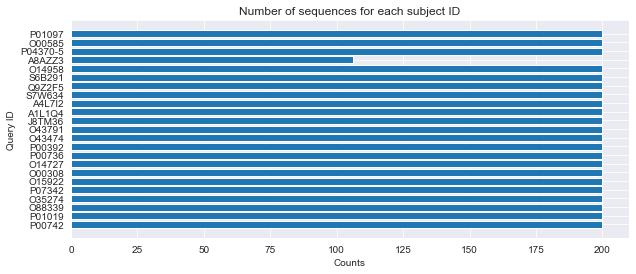

In [235]:
# Plot subject IDs count
figure(figsize=(10, 4))
plt.barh(disordered['query_id'], disordered['count'])
plt.xlabel('Counts')
plt.ylabel('Query ID')
plt.title('Number of sequences for each subject ID')
print(f"The number of sequences containing disordered regions: {disordered['query_id'].nunique()}")
plt.show()

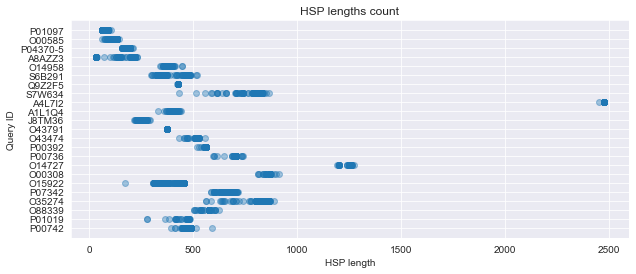

In [236]:
# Plot HSP length count
figure(figsize=(10, 4))
plt.scatter(disordered['hsp_len'], disordered['query_id'], alpha=0.4)
plt.xlabel('HSP length')
plt.ylabel('Query ID')
plt.title('HSP lengths count')
plt.show()

In [237]:
# Dropdown list of Uniprot query IDs for disordered regions
output = widgets.Select(
    options=disordered["query_id"].unique(),
    rows=10,
    description='Uniprot ID: ',
    layout={'width': 'max-content'},
    disabled=False
)
display(output)

Select(description='Uniprot ID: ', layout=Layout(width='max-content'), options=('P00742', 'P01019', 'O88339', …

In [461]:
# Check if there are disordered regions for a particular query ID
id_dis = output.value
selected_dis = disordered[disordered["query_id"].isin([id_dis])]
# selected_dis.head(5)

In [462]:
# Filter the curated_disprot dataframe based on selected ID
curated_query = curated_disprot[curated_disprot['acc'] == id_dis]
curated_query

,acc,evidence,feature,source,start,end,length
7836,P01097,curated,disorder,disprot,28,50,23


### 2. Query ID Analysis

Next, we determine the count of subject IDs for each query ID. It's important to note that we need to summarize the data for all subject IDs that occurred for a particular query, rather than for each individual 'query-sequence' pair.

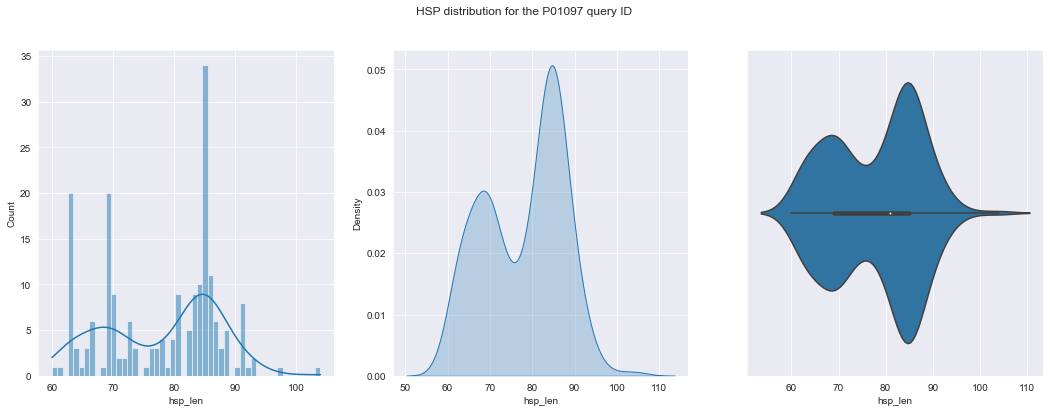

In [463]:
# Create bar plot for HSP hits of selected query ID
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(selected_dis['hsp_len'], kde = True, bins = 50, ax = ax1)
sns.kdeplot(selected_dis['hsp_len'], shade = True, ax = ax2)
sns.violinplot(x = selected_dis['hsp_len'], ax = ax3)
plt.suptitle(f'HSP distribution for the {id_dis} query ID')
plt.show()

The `histplot` shows the distribution of HSP lengths in the selected query ID by grouping the HSP lengths into bins or ranges along the x-axis and displaying the frequency of HSP lengths as the height of the corresponding bar on the y-axis.

The height of the `kdeplot` curve represents the estimated probability density of the variable being plotted at each point on the x-axis. For example, in the case of the HSP length, the height of the curve at a particular value of x represents the estimated density of observations around that value. The area under the curve represents the total probability of all possible values of the variable, which is equal to 1.

The `violinplot` provides the information about the interquartile range (thick gray line), median that is represented by a white dot and the rest of a distribution (thin gray line). The distribution's shape is presented on either side of the gray line through kernel density estimation. The wider sections of the violin plot represent a greater probability of the population taking on a specific value, while the narrower sections indicate a lower probability.

### 3. Multiple Sequence Alignment

Within this framework, we will compare the MSA results obtained directly from the BLAST output with those generated from the ClustalOmega service.

#### 3.1. MSA from the BLAST output
This code iterates through each row of the dataframe for a previously selected query ID. If there is no gap, it maps the amino acid from the subject sequence to the corresponding position in the query sequence, starting from the beginning of the query sequence. The resulting mapped amino acids are then added to a new count. In the end we have a FASTA file with the subject IDs and the aligned sequences.

In [464]:
# # Retrieve a query sequence from query id
# query_sequence = get_fasta(id_dis)
# query_lines = query_sequence.split("\n")
# query_sequence = "".join(query_lines[1:]) # its length will be used for building MSA

In [465]:
# # 1. Build the MSA from the BLAST
# out_file = f'{directory}/results/alignments/output_files/blast/{id_dis}_blast.fasta'
#
# with open(out_file, "w") as fout:
#     mapped_seq = ["-"] * len(query_sequence)
#
#     # Write the header line for the query sequence
#     fout.write(">{}\n".format(id_dis))
#
#     # Map the query sequence to the mapped_seq list
#     c = 0
#     for l_q in query_sequence:
#         if l_q != " " and l_q != '-':
#             mapped_seq[c] = l_q
#             c += 1
#
#     # Write the query_mapped_seq sequence to the output file
#     fout.write("{}\n".format("".join(mapped_seq)))
#
#     # Map the subject sequences to the mapped_seq list and write to the output file
#     for index, row in selected_dis.iterrows():
#         c = 0
#         query_start = row["query_start"]
#         for l_q, l_s in zip(row['query_seq'], row['subject_seq']):
#             if l_q != " " and l_q != '-': # if the initial aa from query is not empty or gapped
#                 mapped_seq[query_start + c - 1] = l_s if l_s != " " else "-" # assign aa to subject
#                 c += 1
#             #if row['subject_id'] == id_dis:
#                 #continue
#         fout.write(">{}\n{}\n".format(row["subject_id"], "".join(mapped_seq)))

#### 3.2. MSA from the ClustalOmega, MAFFT

Initially, we need to preprocess the dataframe into a suitable input format file for ClustalOmega and MAFFT.

In [509]:
# # # 2. Retrieve the unaligned sequences from the local machine
# input_file = f'{directory}/results/alignments/input_files/{id_dis}_input.fasta'
#
# with open(input_file, 'w') as fout:
#     # Write the query sequence to the output file as the first line
#     fout.write(">{}\n{}\n".format(id_dis, query_sequence))
#
#     for index, row in selected_dis.iterrows():
#         accession = row['subject_id']
#         sequence = get_fasta(accession)
#         if id_dis == accession: # remove duplicates
#             continue
#         fout.write(sequence)

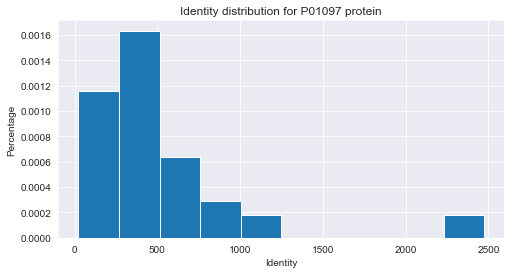

In [511]:
# Plot identity distribution
figure(figsize=(8, 4))
plt.hist(disordered['identity'], bins=10, density=True)  # Set density=True for percentage values
plt.xlabel('Identity')
plt.ylabel('Percentage')
plt.title(f'Identity distribution for {id_dis} protein')
plt.show()

#### Removing redundant regions

For this step we use the input files for ClustalOmega or MAFFT alignment. The goal is to keep only non-redundant regions. We set the threshold for redundancy of 62%. The program implementing the task is called `cd-hit`.

In [514]:
# def calculate_Nf(msa_file, threshold):
#
#     output_file = f"/Users/alina/HMM/results/alignments/input_files/non-redundant/Nf_{id_dis}.fasta"
#     cd_hit_path = "/Users/alina/cd-hit/cd-hit"
#
#     # Run CD-HIT to cluster the sequences (excluding the first line) and remove redundancy
#     cmd = f"{cd_hit_path} -i {msa_file} -o {output_file} -c {threshold} -n 4"
#     subprocess.call(cmd, shell=True)
#
#     # Read the first line from the original MSA file
#     with open(msa_file, "r") as msa_handle:
#         first_record = next(SeqIO.parse(msa_handle, "fasta"))
#
#     # Temporarily store the non-redundant sequences in a list
#     non_redundant_sequences = []
#     with open(output_file, "r") as output_handle:
#         for record in SeqIO.parse(output_handle, "fasta"):
#             non_redundant_sequences.append(record)
#
#     # Write the non-redundant sequences (including the first line) to the output file
#     with open(output_file, "w") as final_handle:
#         SeqIO.write([first_record] + non_redundant_sequences, final_handle, "fasta")
#
#     # Count the number of sequences in the MSA and the non-redundant MSA
#     total_sequences = sum(1 for record in SeqIO.parse(msa_file, "fasta"))
#     non_redundant_sequences_count = len(non_redundant_sequences)
#
#     # Calculate the effective sequences (Nf)
#     Nf = non_redundant_sequences_count / total_sequences
#     print("The number of non-redundant sequences:", non_redundant_sequences_count)
#     print("The total number of sequences:", total_sequences)
#     print("The ratio of non-redundant sequences (Nf):", "{:.2f}".format(Nf))
#
#     return

In [516]:
# Calculate redundancy and the number of effective sequences with calculate_Nf function
calculate_Nf(input_file, 0.62)

Program: CD-HIT, V4.8.1, Jul 26 2023, 11:29:12
Command: /Users/alina/cd-hit/cd-hit -i
         /Users/alina/HMM/results/alignments/input_files/P01097_input.fasta
         -o
         /Users/alina/HMM/results/alignments/input_files/non-redundant/Nf_P01097.fasta
         -c 0.62 -n 4

Started: Thu Jul 27 15:32:16 2023
                            Output                              
----------------------------------------------------------------
total seq: 197
longest and shortest : 165 and 62
Total letters: 18530
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 10M = 10M
Table           : 1 X 3M = 3M
Miscellaneous   : 0M
Total           : 13M

Table limit with the given memory limit:
Max number of representatives: 3988095
Max number of word counting entries: 98289113

comparing sequences from          0  to        197

      197  finished         50  clusters

Approximated maximum memory consumption: 13M
writing new database

Next, we will be working with the newly generated file. It will be uploaded to ebi website, where we will select Pearson/FASTA as the output format. Once we have downloaded the aligned sequences, we can analyze the alignment using Jalview.

In [517]:
# Prepare all sequences for the following comparison
al_blast = f'{directory}/results/alignments/output_files/blast/{id_dis}_blast.fasta'
al_clustal_Nf = f'{directory}/results/alignments/output_files/clustal/non-redundant/Nf_{id_dis}_clustal.fasta'
al_clustal = f'{directory}/results/alignments/output_files/clustal/{id_dis}_clustal.fasta'
# al_mafft = f'{directory}/results/alignments/output_files/mafft/{id_dis}_mafft.fasta'

blast_seqs = get_seqs(al_blast)
clustal_Nf_seqs = get_seqs(al_clustal_Nf)
clustal_seqs = get_seqs(al_clustal)
# mafft_seqs = get_seqs(al_mafft, 'mafft', id_dis)

# The number of sequences may differ
blast_seqs.shape, clustal_seqs.shape, clustal_Nf_seqs.shape # mafft_seqs.shape

((201, 85), (197, 85), (51, 85))

In [520]:
non_redundant = pd.read_csv("nr_0.csv", sep=";")
non_redundant

,id,len,non-red,ratio
0,P00742,199,8,"0,04"
1,P01019,200,5,"0,03"
2,O88339,198,2,"0,01"
3,O35274,200,4,"0,02"
4,P07342,199,4,"0,02"
5,O15922,197,52,"0,26"
6,O00308,198,3,"0,02"
7,O14727,199,2,"0,01"
8,P00736,199,4,"0,02"
9,P00392,192,1,"0,01"


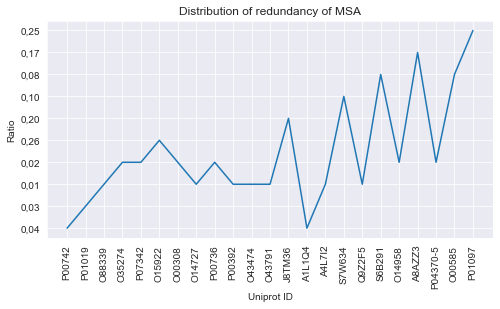

In [522]:
# Plot the redundancy distribution
figure(figsize=(8, 4))
plt.plot(non_redundant['id'], non_redundant['ratio'])
plt.xlabel("Uniprot ID")
plt.ylabel("Ratio")
plt.xticks(rotation='vertical')
plt.title("Distribution of redundancy of MSA")
plt.show()

### 4. Defining disordered regions in MSA

Here we will look at the positions of disordered regions in an alignment. Then we'll extract these regions for the separate analysis.

In [523]:
# Extract the lists of start and end regions
start_regions = curated_query['start'].tolist()
end_regions = curated_query['end'].tolist()
print(f"The lists of start and end positions of the {id_dis} disordered regions: \n"
      f"Start regions: {start_regions}, \n"
      f"End regions: {end_regions}")

The lists of start and end positions of the P01097 disordered regions: 
Start regions: [28], 
End regions: [50]


In [524]:
# Trim disordered regions from MSA BLAST and save the file in the folder
# regions = trim_dis_regions(al_blast, id_dis, start_regions, end_regions)
regions = trim_dis_regions(al_clustal_Nf, id_dis, start_regions, end_regions)

# Look at the resulting regions in an alignment
seqs = get_seqs(regions)
print(id_dis, seqs.shape, type(seqs))
seqs[:10]

P01097 (51, 85) <class 'numpy.ndarray'>


array([['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
        '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
        '-', 'G', 'T', 'P', 'R', 'G', 'S', 'G', 'S', 'E', 'D', 'S', 'F',
        'V', 'K', 'R', 'E', 'R', 'A', 'T', 'E', 'D', 'F', 'F', '-', '-',
        '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
        '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
        '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
        '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
        '-', 'G', 'A', 'P', 'R', 'G', 'V', 'N', 'Q', 'E', 'D', 'S', 'F',
        'T', 'K', 'R', 'E', 'K', 'M', 'N', 'E', 'D', 'Y', 'F', '-', '-',
        '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
        '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
        '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-'

In [482]:
# Split the disordered regions with the help of select_dis_regions function
output_directory = f"{directory}/results/alignments/output_files/disordered"
# separate_disordered_regions = select_dis_regions(al_blast, id_dis, start_regions, end_regions, output_directory)
separate_disordered_regions = select_dis_regions(al_clustal_Nf, id_dis, start_regions, end_regions, output_directory)

# for item in output_directory:
dis_seqs = print_dis_seqs(output_directory, 'disordered', id_dis)
print(id_dis, dis_seqs[0].shape, type(dis_seqs[0]))
print(id_dis, dis_seqs[1].shape, type(dis_seqs[1]))
# print(dis_seqs[1])

# print(id_dis, dis_seqs.shape, type(dis_seqs))
# print(dis_seqs)

P01097 (23,) <class 'numpy.ndarray'>
P01097 (23,) <class 'numpy.ndarray'>


### 5. Analysing the quality of prediction

For calculation of the entropy we use a probability distribution with 20 outcomes, where each outcome has an equal probability of 1/20. Entropy is a measure of the uncertainty or randomness associated with a probability distribution. In this case, since the probability distribution is uniform, the entropy is maximized, meaning that there is maximum uncertainty or randomness associated with the outcomes.

With occupancy we define the proportion of non-missing (non-gap) values in the column.

### 5.1. Calculation of occupancy and entropy for initial MSA

In [483]:
# Calculate the occupancy and entropy for each type of MSA
blast_calc = stats_calculation(blast_seqs)
clustal_Nf_calc = stats_calculation(clustal_Nf_seqs)
clustal_calc = stats_calculation(clustal_seqs)
# mafft_calc = stats_calculation(mafft_seqs)

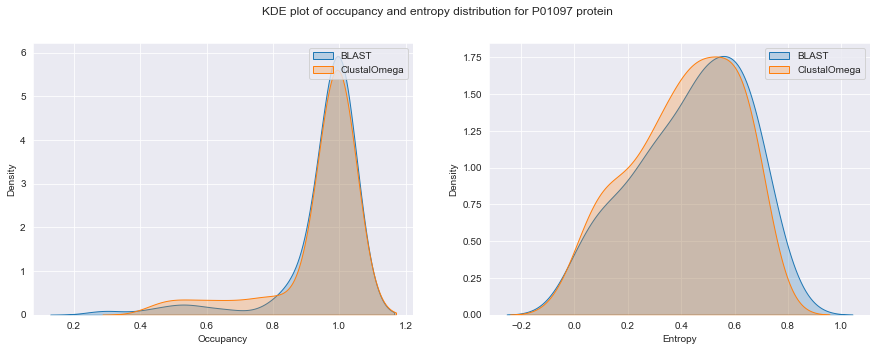

In [484]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# sns.kdeplot(blast_calc['occupancy'], shade = True, ax = ax1)
sns.kdeplot(clustal_Nf_calc['occupancy'], shade = True, ax = ax1)
sns.kdeplot(clustal_calc['occupancy'], shade = True, ax = ax1)
# sns.kdeplot(mafft_calc['occupancy'], shade = True, ax = ax1)

# sns.kdeplot(blast_calc['entropy'], shade = True, ax = ax2)
sns.kdeplot(clustal_Nf_calc['entropy'], shade = True, ax = ax2)
sns.kdeplot(clustal_calc['entropy'], shade = True, ax = ax2)
# sns.kdeplot(mafft_calc['entropy'], shade = True, ax = ax2)

ax1.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax2.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'KDE plot of occupancy and entropy distribution for {id_dis} protein')
plt.show()

ValueError: `bins` must increase monotonically, when an array

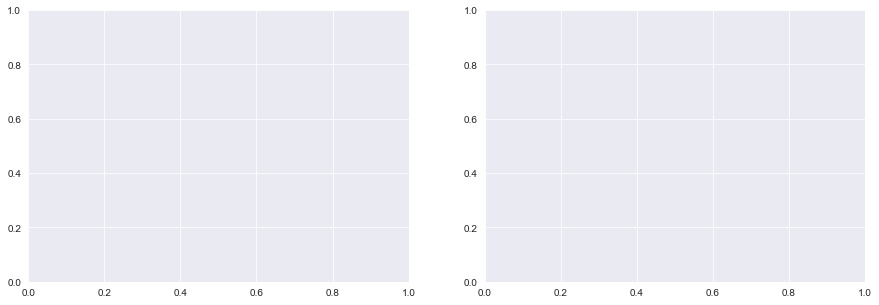

In [485]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ax1.hist(blast_calc['occupancy'])
ax1.hist(clustal_Nf_calc['occupancy'], clustal_calc['occupancy'])
          # mafft_calc['occupancy']])
# ax2.hist(blast_calc['entropy'])
ax2.hist(clustal_Nf_calc['entropy'], clustal_calc['entropy'])
          # mafft_calc['entropy']])

ax1.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax2.legend(['BLAST', 'ClustalOmega', 'MAFFT'])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')

plt.suptitle(f'Histogram of occupancy and entropy distribution for {id_dis} protein')
plt.show()

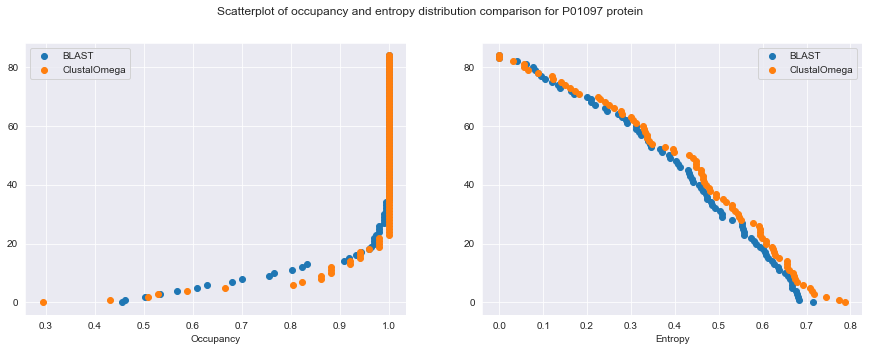

In [486]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ax1.scatter(np.sort(blast_calc['occupancy']), blast_calc['pos'])
ax1.scatter(np.sort(clustal_calc['occupancy']), clustal_calc['pos'])
ax1.scatter(np.sort(clustal_Nf_calc['occupancy']), clustal_Nf_calc['pos'])
# ax1.scatter(np.sort(mafft_calc['occupancy']), mafft_calc['pos'])

# ax2.scatter(np.sort(blast_calc['entropy']), blast_calc['pos'][::-1])
ax2.scatter(np.sort(clustal_calc['entropy']), clustal_calc['pos'][::-1])
ax2.scatter(np.sort(clustal_Nf_calc['entropy']), clustal_Nf_calc['pos'][::-1])
# ax2.scatter(np.sort(mafft_calc['entropy']), mafft_calc['pos'][::-1])

ax1.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax2.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'Scatterplot of occupancy and entropy distribution comparison for {id_dis} protein')
plt.show()

### 5.2. Calculation of occupancy and entropy for disordered regions MSA

#### 5.2.1 Occupancy and entropy for several disordered regions

In [487]:
# Calculate occupancy and entropy for the 1st disordered region
dis_calc0 = stats_calculation(dis_seqs[0])
dis_calc0.head()

,pos,occupancy,entropy,counts
0,0,1.0,0.0,"[(G, 1)]"
1,1,1.0,0.0,"[(T, 1)]"
2,2,1.0,0.0,"[(P, 1)]"
3,3,1.0,0.0,"[(R, 1)]"
4,4,1.0,0.0,"[(G, 1)]"


In [488]:
# Calculate occupancy and entropy for the 2nd disordered region
dis_calc1 = stats_calculation(dis_seqs[1])
dis_calc1.head()

,pos,occupancy,entropy,counts
0,0,1.0,0.0,"[(G, 1)]"
1,1,1.0,0.0,"[(A, 1)]"
2,2,1.0,0.0,"[(P, 1)]"
3,3,1.0,0.0,"[(R, 1)]"
4,4,1.0,0.0,"[(G, 1)]"


/Users/alina/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


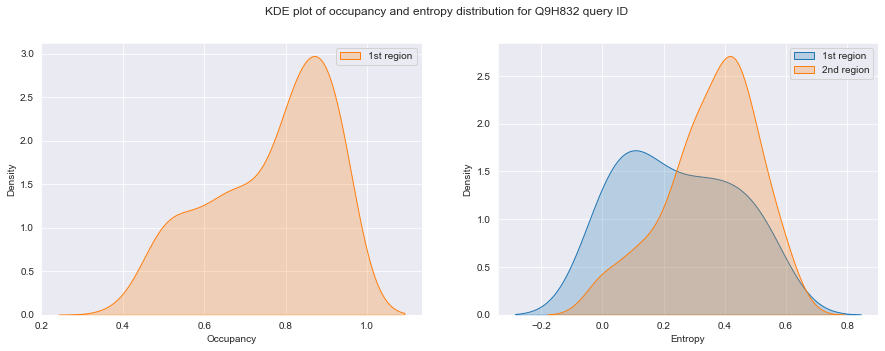

In [47]:
# KDE plot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(dis_calc0['occupancy'], shade = True, ax = ax1)
sns.kdeplot(dis_calc1['occupancy'], shade = True, ax = ax1)
# sns.kdeplot(dis_calc2['occupancy'], shade = True, ax = ax1)

sns.kdeplot(dis_calc0['entropy'], shade = True, ax = ax2)
sns.kdeplot(dis_calc1['entropy'], shade = True, ax = ax2)
# sns.kdeplot(dis_calc2['entropy'], shade = True, ax = ax2)

ax1.legend(['1st region', '2nd region', '3rd region'])
ax2.legend(['1st region', '2nd region', '3rd region'])
ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'KDE plot of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

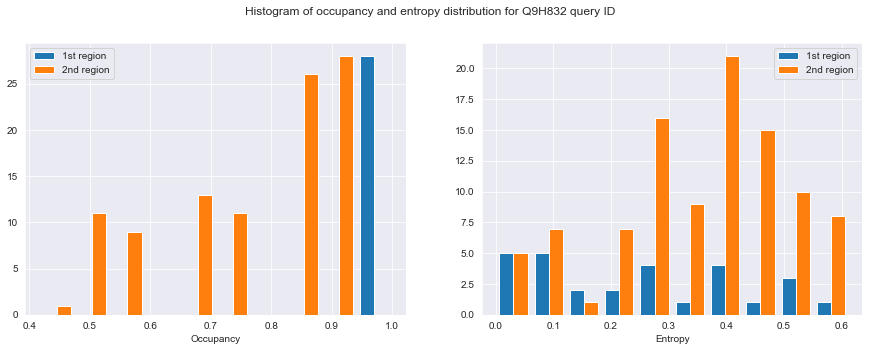

In [49]:
# Barplot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist([dis_calc0['occupancy'], dis_calc1['occupancy'],
          # dis_calc2['occupancy']
         ])
ax2.hist([dis_calc0['entropy'], dis_calc1['entropy'],
          # dis_calc2['entropy']
         ])

ax1.legend(['1st region', '2nd region',
            # '3rd region'
           ])
ax2.legend(['1st region', '2nd region',
            # '3rd region'
           ])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')

plt.suptitle(f'Histogram of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

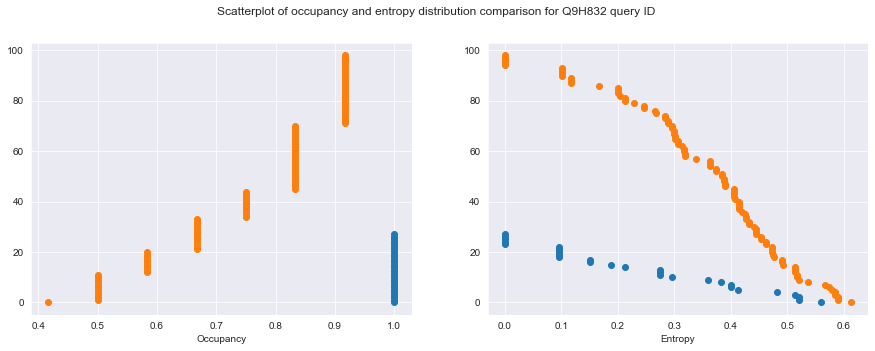

In [50]:
# Scatterplot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(np.sort(dis_calc0['occupancy']), dis_calc0['pos'])
ax1.scatter(np.sort(dis_calc1['occupancy']), dis_calc1['pos'])
# ax1.scatter(np.sort(dis_calc2['occupancy']), dis_calc2['pos'])

ax2.scatter(np.sort(dis_calc0['entropy']), dis_calc0['pos'][::-1])
ax2.scatter(np.sort(dis_calc1['entropy']), dis_calc1['pos'][::-1])
# ax2.scatter(np.sort(dis_calc2['entropy']), dis_calc2['pos'][::-1])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'Scatterplot of occupancy and entropy distribution comparison for {id_dis} query ID')
plt.show()

#### 5.2.2 Occupancy and entropy for one disordered region

In [489]:
# Calculate occupancy and entropy for the region
dis_calc = stats_calculation(dis_seqs)
dis_calc

,pos,occupancy,entropy,counts
0,0,1.000000,0.032215,"[(G, 50), (V, 1)]"
1,1,1.000000,0.442032,"[(A, 24), (S, 15), (T, 5), (G, 5), (I, 1), (F,..."
2,2,1.000000,0.493429,"[(P, 29), (T, 7), (S, 4), (V, 4), (A, 2), (F, ..."
3,3,1.000000,0.150667,"[(R, 46), (P, 2), (L, 1), (G, 1), (D, 1)]"
4,4,1.000000,0.465166,"[(G, 27), (P, 7), (S, 6), (N, 5), (T, 5), (A, 1)]"
5,5,1.000000,0.593037,"[(G, 20), (E, 9), (D, 8), (S, 5), (T, 2), (N, ..."
6,6,0.882353,0.590985,"[(G, 19), (S, 10), (N, 3), (E, 3), (T, 3), (A,..."
7,7,1.000000,0.551445,"[(S, 25), (A, 9), (Q, 5), (G, 3), (T, 3), (K, ..."
8,8,1.000000,0.594776,"[(G, 18), (S, 10), (E, 7), (D, 6), (A, 4), (Q,..."
9,9,1.000000,0.055226,"[(D, 49), (N, 2)]"


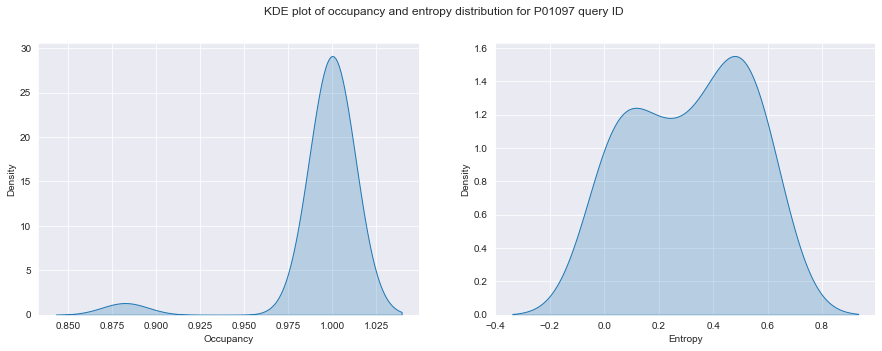

In [490]:
# KDE plot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(dis_calc['occupancy'], shade = True, ax = ax1)
sns.kdeplot(dis_calc['entropy'], shade = True, ax = ax2)

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'KDE plot of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

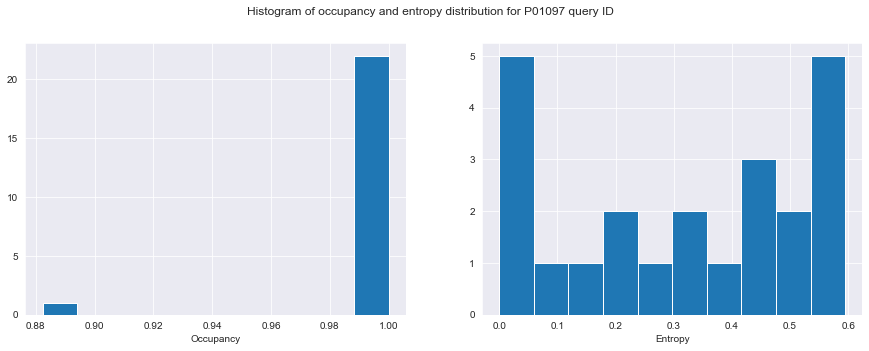

In [491]:
# Barplot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist([dis_calc['occupancy']])
ax2.hist([dis_calc['entropy']])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')

plt.suptitle(f'Histogram of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

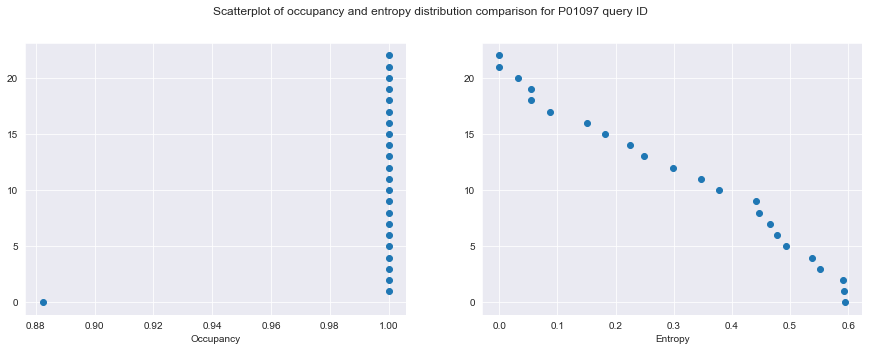

In [492]:
# Scatterplot of occupancy and entropy distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(np.sort(dis_calc['occupancy']), dis_calc['pos'])
ax2.scatter(np.sort(dis_calc['entropy']), dis_calc['pos'][::-1])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'Scatterplot of occupancy and entropy distribution comparison for {id_dis} query ID')
plt.show()